In [1]:
import preprocessing_util as util
import os
import numpy as np
import pandas as pd
import torch

In [3]:
def preprocess(data_dir, dest_dir, final_dimensions=[400,400,400], resample_resolution=[2,2,2]):
    train_images_dir = os.path.join(data_dir, 'train_images/')
    train_label_coordinates_dir = os.path.join(data_dir, 'train_label_coordinates.csv')
    train_series_descriptions_dir = os.path.join(data_dir, 'train_series_descriptions.csv')
    train_labels_dir = os.path.join(data_dir, 'train.csv')
    
    studies = os.listdir(train_images_dir)
    
    dest_data_dir = os.path.join(dest_dir, f'resampled-{resample_resolution[0]}mm_resolution')
    if not os.path.exists(dest_data_dir):
        os.makedirs(dest_data_dir)
    
    for study in studies:
    # for study in ['2780669808']:
        series_ids = os.listdir(os.path.join(train_images_dir, study))
        
        # Get the Severity Label data for this study (one-hot encoded)
        labels = util.load_label_data(train_labels_dir, study)
        
        for series in series_ids:
        # for series in ['2149514139']:
            scan = util.load_sample(train_images_dir, study, series)
            
            # Skip this series if it has an error
            if not util.check_valid_scan(scan) :
                print(f'Skipping study {study} series {series}, multiple scans dumped in same directory')
                continue

            # Get the coordinate data for this series
            coord_data, coordinate_data_mask = util.load_coord_data(train_label_coordinates_dir, int(series))

            # Stack the scan together
            slices = np.stack([s.pixel_array for s in scan], dtype=np.float32)
            
            # Resample the Images and Coordinates to new resolution
            resampled_image, resampled_coord_data, new_spacing = util.resample_with_coordinates( slices , scan, coord_data, resample_resolution)
            
            # Transform Sagittal data to Axial Plane
            # orientation = util.get_series_orientation(train_series_descriptions_dir, int(series))
            # if 'sagittal' in orientation.lower():
            #     resampled_image, resampled_coord_data = util.sagittal_to_axial(resampled_image, resampled_coord_data)
            
            resampled_coord_data = np.array(resampled_coord_data, dtype=np.float32)
            
            #--------------------------
            # Cropping will be done during data augmentation at runtime. Leaving this all here for now to clean later
            #--------------------------
            
            # crop / zero-pad data
            # cropped_image, dim_diffs = util.crop_or_pad_image(resampled_image, final_dimensions)
            
            # dim_adjustments = [dim[0] for dim in dim_diffs]
            # cropped_coords, in_bounds_coords_mask = util.adjust_coordinates(resampled_coord_data, dim_adjustments, final_dimensions)
            
            # OOB_coords = [ data_mask == 1 and bounds_mask == 0 for data_mask, bounds_mask in zip(coordinate_data_mask, in_bounds_coords_mask)]
            # for clo in np.array(util.condition_level_order)[OOB_coords]:
            #     print(f'series {series} {clo} Out of Bounds after cropping')
            
            #--------------------------

            # combine masks
            mask = coordinate_data_mask #* in_bounds_coords_mask
            
            # Mask the labels to only predict labels that this scan determines
            assert labels.shape[0] == 25
            series_label_data = [ [0,0,0,1] if mask[i] == 0 else labels[i] for i in range(25)]
            series_label_data = np.array(series_label_data)
            
            #Exports: image, coordinates, labels, mask
            
            if not os.path.exists(os.path.join(dest_data_dir, study)):
                os.makedirs(os.path.join(dest_data_dir, study))
            if not os.path.exists(os.path.join(dest_data_dir, study, series)):
                os.makedirs(os.path.join(dest_data_dir, study, series))
            
            export_dest = os.path.join(dest_data_dir, study, series)
            
            assert type(resampled_image) == np.ndarray
            assert type(resampled_coord_data) == np.ndarray
            assert type(series_label_data) == np.ndarray
            assert type(mask) == np.ndarray
            np.save(os.path.join(export_dest,f'{series}_image.npy'), resampled_image)
            np.save(os.path.join(export_dest,f'{series}_coordinates.npy'), resampled_coord_data)
            np.save(os.path.join(export_dest,f'{series}_labels.npy'), series_label_data)
            np.save(os.path.join(export_dest,f'{series}_mask.npy'), mask)
    return


In [4]:
data_dir = '../data/'
dest_dir = '../preprocessing/datasets/'

preprocess(data_dir, dest_dir, final_dimensions=[300,300,300], resample_resolution=[1.5,1.5,1.5])


KeyboardInterrupt: 

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology
import matplotlib.pyplot as plt
import numpy as np

def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

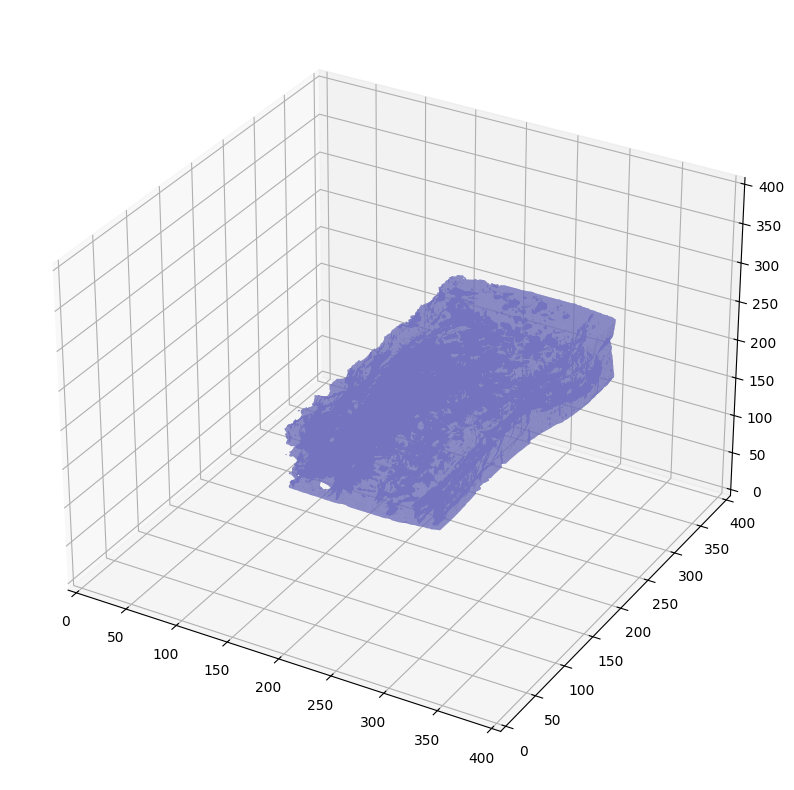

In [ ]:
# plot_3d(np.load('datasets/resampled-400mm_width-1mm_resolution/2780669808/2149514139/2149514139_image.npy'), 50)
